In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy as scipy
import pyspark
import matplotlib as mpl
from pyspark.ml.clustering import GaussianMixture
from pyspark.ml.pipeline import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
from pyspark import keyword_only
from pyspark.sql import SQLContext, Row
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import IntegerType, LongType, DoubleType, StringType , FloatType
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer
from pyspark.sql.types import IntegerType, LongType, DoubleType, StringType
from scipy.stats import ttest_ind
from sklearn.cross_validation import train_test_split
import pyspark
#import xgboost



In [4]:
sc = pyspark.SparkContext(master='local[*]')

In [5]:
sqlContext = SQLContext(sc)

In [9]:
path_to_file = '/home/jovyan/work/Big_Data_Course_UM/Proyecto_Final/Kobe/trabajoFinal/data.csv'

In [10]:
raw_data_rdd = sc.textFile(path_to_file).map(lambda x: [y.strip() for y in x.split(',')])

In [11]:
raw_data_rdd.take(2)

[[u'action_type',
  u'combined_shot_type',
  u'game_event_id',
  u'game_id',
  u'lat',
  u'loc_x',
  u'loc_y',
  u'lon',
  u'minutes_remaining',
  u'period',
  u'playoffs',
  u'season',
  u'seconds_remaining',
  u'shot_distance',
  u'shot_made_flag',
  u'shot_type',
  u'shot_zone_area',
  u'shot_zone_basic',
  u'shot_zone_range',
  u'team_id',
  u'team_name',
  u'game_date',
  u'matchup',
  u'opponent',
  u'shot_id'],
 [u'Jump Shot',
  u'Jump Shot',
  u'10',
  u'20000012',
  u'33.9723',
  u'167',
  u'72',
  u'-118.1028',
  u'10',
  u'1',
  u'0',
  u'2000-01',
  u'27',
  u'18',
  u'',
  u'2PT Field Goal',
  u'Right Side(R)',
  u'Mid-Range',
  u'16-24 ft.',
  u'1610612747',
  u'Los Angeles Lakers',
  u'2000-10-31',
  u'LAL @ POR',
  u'POR',
  u'1']]

[[u'action_type',0
  u'combined_shot_type',
  u'game_event_id',
  u'game_id',
  u'lat',4
  u'loc_x', 5 
  u'loc_y', 6
  u'lon',7
  u'minutes_remaining',
  u'period',
  u'playoffs',
  u'season',11
  u'seconds_remaining',12
  u'shot_distance',13
  u'shot_made_flag',
  u'shot_type',
  u'shot_zone_area',
  u'shot_zone_basic',
  u'shot_zone_range',
  u'team_id',19
  u'team_name',20
  u'game_date',21
  u'matchup',
  u'opponent',
  u'shot_id'],
 [u'Jump Shot',0
  u'Jump Shot',
  u'10',
  u'20000012',
  u'33.9723',
  u'167',
  u'72',
  u'-118.1028',7
  u'10',
  u'1',
  u'0',10
  u'2000-01',11
  u'27',
  u'18',13
  u'',
  u'2PT Field Goal',
  u'Right Side(R)',
  u'Mid-Range',
  u'16-24 ft.',18
  u'1610612747',
  u'Los Angeles Lakers',
  u'2000-10-31',21
  u'LAL @ POR', 22
  u'POR',
  u'1']]
  4 7 13 19 20 22

In [12]:
def local_trans(val):
    res = 1
    if '@' in val:
        res = 0
    return res

def xy_to_rad(x,y):
    rho = float(np.sqrt(x**2 + y**2))
    phi = float(np.arctan2(y, x))
    return [rho, phi]

In [13]:
header = raw_data_rdd.first()
header_use = header[:4] + header[5:7] + header[8:13] + header[14:19] + [header[21]] + header[23:] + ["local", 'distance', 'angle(radians)'] #borramos   4 7 13 19 20 22
print len(header_use)
clean_data_df = raw_data_rdd.filter(lambda row : (row != header) and (row[14] != '')).map(lambda x: [x[0],x[1],int(x[2]),int(x[3]),float(x[5]),float(x[6]),int(x[8]),int(x[9]),int(x[10]),x[11],int(x[12]),int(x[14]),x[15],x[16],x[17],x[18],x[21],x[23],x[24],local_trans(x[22])] + xy_to_rad(int(x[5]),int(x[6])) ).toDF(header_use)


22


In [14]:
clean_data_df.show()

+-----------------+------------------+-------------+--------+------+-----+-----------------+------+--------+-------+-----------------+--------------+--------------+--------------------+--------------------+---------------+----------+--------+-------+-----+------------------+------------------+
|      action_type|combined_shot_type|game_event_id| game_id| loc_x|loc_y|minutes_remaining|period|playoffs| season|seconds_remaining|shot_made_flag|     shot_type|      shot_zone_area|     shot_zone_basic|shot_zone_range| game_date|opponent|shot_id|local|          distance|    angle(radians)|
+-----------------+------------------+-------------+--------+------+-----+-----------------+------+--------+-------+-----------------+--------------+--------------+--------------------+--------------------+---------------+----------+--------+-------+-----+------------------+------------------+
|        Jump Shot|         Jump Shot|           12|20000012|-157.0|  0.0|               10|     1|       0|2000-01

In [16]:
class normalize_Col(Transformer, HasInputCol, HasOutputCol):
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None):
        super(normalize_Col, self).__init__()
        kwargs = self.__init__._input_kwargs
        self.setParams(**kwargs)
        
    @keyword_only 
    def setParams(self, inputCol=None, outputCol=None):
        kwargs = self.setParams._input_kwargs
        return self._set(**kwargs)
        
    def _transform(self, dataset):
        input_col = dataset[self.getInputCol()]
        out_col = self.getOutputCol()
        max_val =  list(dataset.agg({self.getInputCol(): "max"}).collect()[0])[0] 
        min_val =  list(dataset.agg({self.getInputCol(): "min"}).collect()[0])[0]
        max_val = max(abs(max_val), abs(min_val))
        udf = UserDefinedFunction(lambda x: norm_2_std(x, min_val, max_val), DoubleType())
        return dataset.withColumn(out_col, udf(input_col))

def norm_2_std(value, min_val, max_val):
    return float(value)/(max_val)

In [78]:
class Cluster_Column(Transformer, HasInputCol, HasOutputCol):
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None, k=None, seed=None):
        super(Cluster_Column, self).__init__()
        self.k = Param(self, "k", "")
        self._setDefault(k="13")
        self.seed = Param(self, "seed", "")
        self._setDefault(seed="42")
        kwargs = self.__init__._input_kwargs
        self.setParams(**kwargs)
        
    @keyword_only 
    def setParams(self, inputCol=None, outputCol=None, k=None, seed=None):
        kwargs = self.setParams._input_kwargs
        return self._set(**kwargs)
    
    def setK(self, value):
        self._paramMap[self.k] = value
        return self

    def getK(self):
        return self.getOrDefault(self.k)
   
    def setSeed(self, value):
        self._paramMap[self.seed] = value
        return self

    def getSeed(self):
        return self.getOrDefault(self.seed)
        
    def _transform(self, dataset):
        gmm = GaussianMixture().setK(self.getK()).setSeed(self.getSeed()).setFeaturesCol(self.getInputCol())
        model = gmm.fit(dataset)
        pred_df = model.transform(dataset)
        
        return pred_df.drop("probability").withColumnRenamed("prediction", self.getOutputCol())

In [79]:
norm_dist = normalize_Col(inputCol="distance", outputCol="distance_norm")
norm_ang = normalize_Col(inputCol="angle(radians)", outputCol="angle_norm")
assembler_for_clust = VectorAssembler(inputCols=['distance_norm', 'angle_norm'],
                            outputCol='features_clust_dist_rad')
cluster_column_dist_rad = Cluster_Column(inputCol="features_clust_dist_rad", outputCol="loc_cluster", k=13, seed=42)
pipeline_complete = Pipeline(stages=[norm_dist,norm_ang,assembler_for_clust,cluster_column_dist_rad])
pipelineModel = pipeline_complete.fit(clean_data_df)
output = pipelineModel.transform(clean_data_df)

+-----------+
|loc_cluster|
+-----------+
|          0|
|          0|
|          2|
|          1|
|          9|
|          1|
|          4|
|          4|
|         10|
|          2|
|          4|
|          0|
|          8|
|          5|
|         10|
|          0|
|          6|
|          2|
|          6|
|          0|
+-----------+
only showing top 20 rows



In [39]:
stringIndexer_action_type= StringIndexer(inputCol="action_type", outputCol="action_type_idx")
stringIndexer_combined_shot_type= StringIndexer(inputCol="combined_shot_type", outputCol="combined_shot_type_idx")
stringIndexer_shot_type= StringIndexer(inputCol="shot_type", outputCol="shot_type_idx")
stringIndexer_shot_zone_area= StringIndexer(inputCol="shot_zone_area", outputCol="shot_zone_area_idx")
stringIndexer_shot_zone_basic= StringIndexer(inputCol="shot_zone_basic", outputCol="shot_zone_basic_idx")
stringIndexer_shot_zone_range= StringIndexer(inputCol="shot_zone_range", outputCol="shot_zone_range_idx")
stringIndexer_opponent= StringIndexer(inputCol="shot_zone_basic", outputCol="shot_zone_basic_idx")
norm_dist = normalize_Col(inputCol="distance", outputCol="distance_norm")
norm_ang = normalize_Col(inputCol="angle(radians)", outputCol="angle_norm")
assembler_for_clust = VectorAssembler(inputCols=['distance_norm', 'angle_norm'],
                            outputCol='features_clust_dist_rad')
cluster_column_dist_rad = Cluster_Column(inputCol="features_clust_dist_rad", outputCol="loc_cluster", k=13, seed=42)

pipeline_complete = Pipeline(stages=[norm_dist,norm_ang,assembler_for_clust])
pipelineModel = pipeline_complete.fit(clean_data_df)
output = pipelineModel.transform(clean_data_df)

gmm = GaussianMixture().setK(13).setSeed(42).setFeaturesCol("features_clust_dist_rad")
model = gmm.fit(output)

transformed = model.transform(output)

#kobe_Data_df_na_dropped['shotLocationCluster'] = gaussianMixtureModel.predict(clean_data_df[['loc_x','loc_y']])


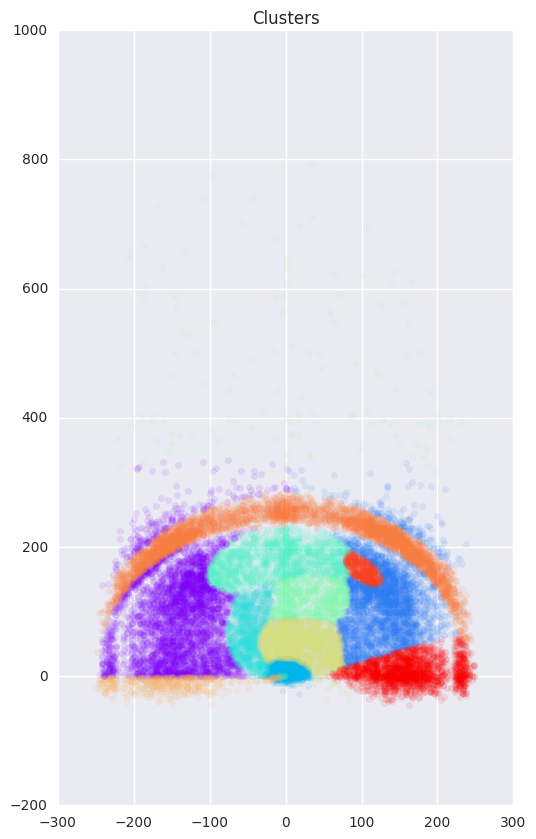

In [19]:
import matplotlib.cm as cm
plt.figure(figsize=(20,10))

def scatter_plot_by_category(dataframe, feature):
    alpha = 0.1
    groups = dataframe.groupby(feature)
    cs = cm.rainbow(np.linspace(0, 1, len(groups)))
    for g, c in zip(groups, cs):
        plt.scatter(g[1].loc_x, g[1].loc_y, color=c, alpha=alpha)

# shot_zone_area
plt.subplot(131)
scatter_plot_by_category(transformed.toPandas(), 'prediction')
plt.title('Clusters')


In [20]:
clean_data_df_w_clust = clean_data_df.withcolumn(transformed.prediction)

AttributeError: 'DataFrame' object has no attribute 'withcolumn'

In [ ]:
kobe_Data_df_na_some_columns_dropped = kobe_Data_df_na_some_columns_dropped.drop('minutes_remaining', 1)
kobe_Data_df_na_some_columns_dropped = kobe_Data_df_na_some_columns_dropped.drop('seconds_remaining', 1)

A su vez, si analizamos los features matchup y opponent vemos que lo que en realidad nos interesa es si esta jugando de local o visitante y el oponente por lo tanto vamos a transformar matchup a una columna que es 1 si esta jugando de visitante y 0 si esta jugando de local

In [ ]:
class matchUpTransformer(Transformer, HasInputCol, HasOutputCol): 
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None):
        super(matchUpTransformer, self).__init__()
        kwargs = self.__init__._input_kwargs
        self.setParams(**kwargs)
        
    @keyword_only 
    def setParams(self, inputCol=None, outputCol=None):
        kwargs = self.setParams._input_kwargs
        return self._set(**kwargs)
        
    def _transform(self, dataset):
        in_col = dataset[self.getInputCol()]
        out_col = self.getOutputCol()
        udf = UserDefinedFunction(lambda x: clean_value_Match_Up(x),IntegerType())
        return dataset.withColumn(out_col, udf(in_col))

def clean_value_Match_Up(in_value):
    if (in_value):
        if "@" in in_value.strip():
            return 1
        else:
            return 0
    else:
        return 'error missing value not expected'

In [ ]:
match_up_transformer = matchUpTransformer(inputCol='matchup', outputCol='matchup_transformer')

In [ ]:
kobe_Data_df_na_some_columns_dropped = match_up_transformer.transform(kobe_Data_df_na_some_columns_dropped)

In [ ]:
kobe_Data_df_na_some_columns_dropped

El feature playoff tambien es relevante dado que generalmente en los play

En un principio, el feature shot_zone_basic lo vamos a dejar porque mas alla de que tenemos la distancia y angulo al aro, estas zonas pueden marcale al modelo informacion relevante porque podria juntar los tiros dentro de mid-range, por ejemplo, en un rango de distancias. Despues le sacaremos esta variable para ver si mejora el arbol. Tambien, creemos que con el resultado del clustering y este dato tambien tienen mucho en comun lo que nos da otra razon para eliminarlo.

En cambio, la variable shot_zone_range no parece util porque como marca el grafico son medios anillos concentricos con el aro, que dadas las coordenadas polares no parecen aportar informacion.

(hacer graficas de ambos para explicar)

In [ ]:
import matplotlib.cm as cm
plt.figure(figsize=(20,10))

def scatter_plot_by_category(dataframe, feature):
    alpha = 0.1
    groups = dataframe.groupby(feature)
    cs = cm.rainbow(np.linspace(0, 1, len(groups)))
    for g, c in zip(groups, cs):
        plt.scatter(g[1].loc_x, g[1].loc_y, color=c, alpha=alpha)

# shot_zone_area
plt.subplot(131)
scatter_plot_by_category(kobe_Data_df_na_some_columns_dropped, 'shot_zone_area')
plt.title('shot_zone_area')

# shot_zone_basic
plt.subplot(132)
scatter_plot_by_category(kobe_Data_df_na_some_columns_dropped, 'shot_zone_basic')
plt.title('shot_zone_basic')

# shot_zone_range
plt.subplot(133)
scatter_plot_by_category(kobe_Data_df_na_some_columns_dropped, 'shot_zone_range')
plt.title('shot_zone_range')

In [ ]:
kobe_Data_df_na_some_columns_dropped.head()


In [ ]:
kobe_Data_df_na_some_columns_dropped.describe(include=['O'])

In [ ]:
cols_categoric = [ "action_type", "combined_shot_type", "season", "shot_type", "shot_zone_area", "shot_zone_basic", "shot_zone_range", "game_date", "matchup", "opponent"]
df_dummies = pd.get_dummies(columns=cols_categoric)
kobe_Data_with_idx = kobe_Data_df_na_some_columns_dropped.join(df_dummies, how='outer')

In [ ]:
cat_columns = kobe_Data_df_na_some_columns_dropped.select_dtypes(['O']).columns
kobe_Data_df_na_some_columns_dropped[cat_columns] = kobe_Data_df_na_some_columns_dropped[cat_columns].astype('category')
kobe_Data_df_na_some_columns_dropped[cat_columns] = kobe_Data_df_na_some_columns_dropped[cat_columns].apply(lambda x: x.cat.codes)

In [ ]:
kobe_Data_df_na_some_columns_dropped.select_dtypes(['O']).columns